# Sentiment Analysis on Twitter Data

In [3]:
!pip install tweepy

  Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fdf8c743908>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/tweepy/
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 153kB 971kB/s ta 0:00:01
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tweepy
import nltk

In [5]:
!pip install textblob

    100% |████████████████████████████████| 645kB 672kB/s ta 0:00:01
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Downloading all the necessary data for cleaning the tweets from NLTK function

In [4]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jithin Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Jithin
[nltk_data]     Sasikumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 531kB/s ta 0:00:01
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install vaderSentiment

    100% |████████████████████████████████| 133kB 402kB/s ta 0:00:01
You are using pip version 9.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize.treebank import TreebankWordDetokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pylab import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from itertools import chain
# from sklearn.metrics import plot_confusion_matrix


### Dataset from nltk corpus

In [2]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

### Plot to visualize the number of the positive and negative tweets taken for training the classifier

5000 5000


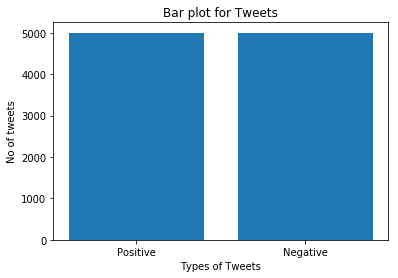

In [3]:
pos=len(positive_tweets)
neg=len(negative_tweets)
print(pos,neg)
lenn=[pos,neg]
b=np.arange(len(lenn))
bars=('Positive','Negative')
plt.title('Bar plot for Tweets')
plt.bar(b,lenn)
plt.xticks(b,bars)
plt.xlabel('Types of Tweets')
plt.ylabel('No of tweets')
plt.show()

### The Tokenized function from NLTK gives the tokens from the tweets

In [4]:
print(tweet_tokens[0])

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


### Data pre-processing: removing links, special characters and stopwords

In [5]:
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []
    words = []

    for token, tags in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tags.startswith("NN"):
            pos = 'n'
        elif tags.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    
    for text in cleaned_tokens:  
        soup = BeautifulSoup(text, 'html5lib')
        souped = soup.get_text()
        stripped = re.sub(combined_pat, '', souped)
        try:
            clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
        except:
            clean = stripped
        letters_only = re.sub("[^a-zA-Z]", " ", clean)
        lower_case = letters_only.lower()
        words.append(tok.tokenize(lower_case))
        final_tokens = [j for i in words for j in i]
    
    return final_tokens


### The noise removed tokens are displayed 

In [6]:
print(remove_noise(tweet_tokens[0], stop_words))

['followfriday', 'top', 'engage', 'member', 'community', 'week']


### Adding all the cleaned tokens of the tweets into a list of list

In [7]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [8]:
print(positive_cleaned_tokens_list[:10])

[['followfriday', 'top', 'engage', 'member', 'community', 'week'], ['hey', 'james', 'odd', 'please', 'call', 'contact', 'centre', 'able', 'assist', 'many', 'thanks'], ['listen', 'last', 'night', 'bleed', 'amazing', 'track', 'scotland'], ['congrats'], ['yeaaaah', 'yippppy', 'accnt', 'verify', 'rqst', 'succeed', 'get', 'blue', 'tick', 'mark', 'fb', 'profile', 'day'], ['one', 'irresistible', 'flipkartfashionfriday'], ['like', 'keep', 'lovely', 'customer', 'wait', 'long', 'hope', 'enjoy', 'happy', 'friday', 'lwwf'], ['second', 'thought', 'enough', 'time', 'dd', 'new', 'short', 'enter', 'system', 'sheep', 'must', 'buy'], ['jgh', 'go', 'bayan', 'd', 'bye'], ['act', 'mischievousness', 'call', 'etl', 'layer', 'in', 'house', 'warehouse', 'app', 'katamari', 'well', 'name', 'imply', 'p']]


In [9]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)


## Visualization using word cloud

In [10]:
pos_word_list = list(chain.from_iterable(positive_cleaned_tokens_list))
pos_words = ' '.join(pos_word_list)
pos_words

neg_word_list = list(chain.from_iterable(negative_cleaned_tokens_list))
neg_words = ' '.join(neg_word_list)

### Positive Tweets

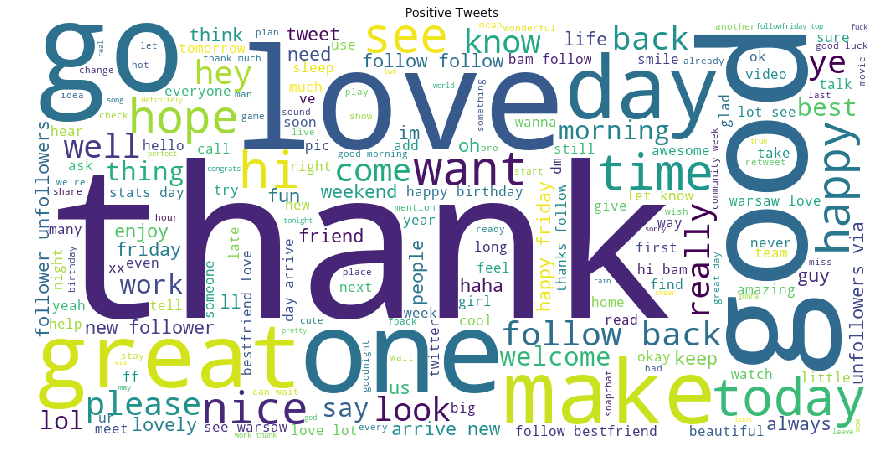

In [11]:
wc = WordCloud(width = 1000, height = 500,background_color='white')
img = wc.generate(pos_words)
plt.figure(figsize=(15,8))
plt.title("Positive Tweets")
plt.imshow(img)
plt.axis("off")
plt.show()

### Negative Tweets

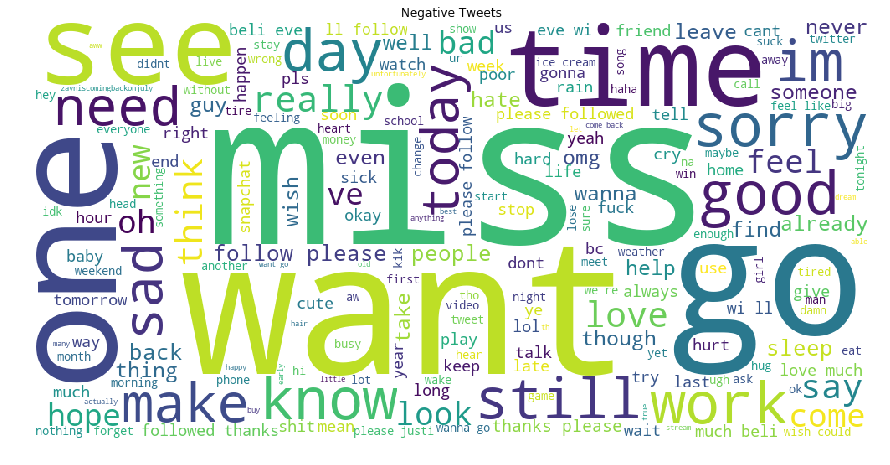

In [12]:
wcc = WordCloud(width = 1000, height = 500,background_color='white')
imgg = wcc.generate(neg_words)
plt.figure(figsize=(15,8))
plt.title("Negative Tweets")
plt.imshow(imgg)
plt.axis("off")
plt.show()

### Sentiment analysis using Naive Bayes Classifier

In [13]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset


print('Length of Positive Tweets :' , len(positive_dataset))
print('Length of Negative Tweets :' ,len(negative_dataset))
print('Length of Total Dataset :' ,len(dataset))

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

print('Length of Training Dataset :' ,len(train_data))
print('Length of Testing Datset :' ,len(test_data))

print(train_data[:10])

Length of Positive Tweets : 5000
Length of Negative Tweets : 5000
Length of Total Dataset : 10000
Length of Training Dataset : 7000
Length of Testing Datset : 3000
[({'ya': True}, 'Negative'), ({'visit': True, 'robbenisland': True, 'cultural': True, 'experience': True, 'try': True, 'whale': True, 'watch': True, 'aquatic': True, 'safari': True, 'either': True, 'great': True}, 'Positive'), ({'first': True, 'leg': True, 'tour': True, 'go': True, 'well': True, 'd': True, 'music': True, 'band': True, 'rock': True, 'magictrik': True}, 'Positive'), ({'retweet': True, 'pleaaase': True}, 'Negative'), ({'nobody': True, 'go': True}, 'Negative'), ({'there': True, 's': True, 'milk': True, 'leave': True, 'cereal': True}, 'Negative'), ({'fine': True}, 'Negative'), ({'pretty': True, 'hair': True}, 'Negative'), ({'twitter': True, 'allow': True, 'retweet': True, 'blog': True, 'post': True, 'since': True, 'think': True, 'interested': True, 'link': True, 'feed': True}, 'Positive'), ({'wanna': True, 'go': 

### NaiveBayes Classifier Training

In [14]:
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.7583333333333333
Most Informative Features
                     sad = True           Negati : Positi =     32.6 : 1.0
                      ff = True           Positi : Negati =     23.0 : 1.0
                follower = True           Positi : Negati =     21.4 : 1.0
                 welcome = True           Positi : Negati =     19.8 : 1.0
                    glad = True           Positi : Negati =     19.6 : 1.0
                     bam = True           Positi : Negati =     19.6 : 1.0
                       d = True           Positi : Negati =     18.2 : 1.0
                followed = True           Negati : Positi =     14.6 : 1.0
               goodnight = True           Positi : Negati =     13.0 : 1.0
              appreciate = True           Positi : Negati =     13.0 : 1.0
None


### Creating labled data frame with pre-processed sentences. 

In [15]:
pos_cleaned_sent=[]
neg_cleaned_sent=[]
for tokens in positive_cleaned_tokens_list:
    pos_cleaned_sent.append(TreebankWordDetokenizer().detokenize(tokens))
    
for tokens in negative_cleaned_tokens_list:
    neg_cleaned_sent.append(TreebankWordDetokenizer().detokenize(tokens))
    
COLS=['tweet','ground_truth']
cleaned_labled_df = pd.DataFrame(columns=COLS)

for tweet in pos_cleaned_sent:
    new_entry = [tweet,'pos']
    labled_tweet = pd.DataFrame([new_entry], columns=COLS)
    cleaned_labled_df = cleaned_labled_df.append(labled_tweet, ignore_index=True)
    
for tweet in neg_cleaned_sent:
    new_entry1 = [tweet,'neg']
    labled_tweet = pd.DataFrame([new_entry1], columns=COLS)
    cleaned_labled_df = cleaned_labled_df.append(labled_tweet, ignore_index=True)

### Sentiment analysis using TextBlob and Vader

In [16]:
class RuleBasedMethods():
    def __init__(self,tweets):
        self.tweetText = tweets
        self.analyzer = SentimentIntensityAnalyzer()
        self.polarity = 0
        self.subjectivity = 0
        self.new_entry = []
        self.COLS = ['tweet', 'sentiment_TextBlob','subjectivity_TextBlob','polarity_TextBlob','sentiment_score_Vader']
        self.df = pd.DataFrame(columns=self.COLS)
            
    def plot_boxplot(self):
        """Plots box pot for comparison between """
        boxplot = self.df.boxplot(column=['polarity_TextBlob','sentiment_score_Vader'], 
                     fontsize = 15,grid = True, vert=True,figsize=(10,10,))
        plt.ylabel('Range')
        plt.title('Box plot for polarity of TextBlob and compound score of Vader')
        
    def accuracy(self,method,new_df):
        if (method=='Vader'):
            pred = 'V.senti.lable'
        elif(method=='TextBlob'):
            pred = 'TB.senti.lable'
        else:
            print("wrong input")
        acc = accuracy_score(new_df['ground_truth'], new_df[pred])
        print("Acurracy for  "+ method +" is: ",acc)
        
    def plot_conf_matrix(self,method,new_df):
        if (method=='Vader'):
            test = new_df['V.senti.lable'].tolist()
        elif(method=='TextBlob'):
            test = new_df['TB.senti.lable'].tolist()
        else:
            print("wrong input")
        pred = new_df['ground_truth'].tolist()
        #test = new_df[pred].tolist()
       
        labels = ['pos', 'neg']
        cm = confusion_matrix(test, pred, labels)
        
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['pos', 'neg']); ax.yaxis.set_ticklabels(['neg', 'pos']);

        
    def plot_density(self,method):
        if (method=='Vader'):
            tag = 'sentiment_score_Vader'
        elif(method=='TextBlob'):
            tag = 'polarity_TextBlob'
        else:
            print("wrong input")
        sns.distplot(self.df[tag], hist=True, kde=True, 
             bins=int(30), color = 'darkred',
             hist_kws={'edgecolor':'black'},axlabel ='Polarity')
        plt.title('Density distribution')
        
        
    def create_dataframe(self,cals_tag):
        
        """Creates data frame for analysis with lables based on sentiment scores of TextBlob and Vader"""
        
        for t in self.tweetText:
            analysis = TextBlob(t)
            self.sentiment = analysis.sentiment
            self.polarity = analysis.sentiment.polarity
            self.subjectivity = analysis.sentiment.subjectivity
            vader_score = self.analyzer.polarity_scores(t)["compound"]
            new_entry = [t,self.sentiment,self.subjectivity,self.polarity,vader_score]
            sentimet_df = pd.DataFrame([new_entry], columns=self.COLS)
            self.df = self.df.append(sentimet_df, ignore_index=True)
            # adding lables according to sentiments
            if(cals_tag==0):
                self.df['TB.senti.lable'] =['neg' if x<=0.0 else 'pos' for x in self.df['polarity_TextBlob']]
                self.df['V.senti.lable'] =['neg' if x<0.0 else 'pos' for x in self.df['sentiment_score_Vader']]
             
            elif(cals_tag==1):
                self.df['TB.senti.lable'] =['neg' if x<=0.0 else 'pos' if x>0 else 'neu' for x in self.df['polarity_TextBlob']]
                self.df['V.senti.lable'] =['neg' if x<0.0 else 'pos' if x>0 else 'neu' for x in self.df['sentiment_score_Vader']]
             
        return self.df

### Data Collection Using Tweepy

### Here the user can enter their search term and check for the sentiment analysis of their Topic entered

In [23]:
import tweepy,csv,re,json
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

tweetText = []
consumer_key='vn4Bchk1jcxRQY4Hlea4dmpkS'
consumer_secret ='9aN4JfIyM9oChyqNjVx68OdFahh68HPYcyzzD7jcIFDQ26WBWB'
access_token = '1267422786479423494-zHorrWgAMF2kFGhBZSp62qLLOrJVcz'
access_token_secret ='fVN4HX1bVllOEHS9EDsSNCOmg2dUzsJwGRD06IZHz3oqQ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


# input for term to be searched and how many tweets to search
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

# searching for tweets
tweets = tweepy.Cursor(api.search, q=searchTerm, lang = "en").items(NoOfTerms)


for tweet in tweets:
    tweetText.append(tweet.text)
print(' ')
print('-------------------Tweets from Tweepy API------------------------------------')
print(tweetText)
print(' ')
final_tweets = []

for i in tweetText:
    final_tweets.append(remove_noise(word_tokenize(i)))
    
print(' ')
print('-------------------Sentiment Analysis from Naive Bayes Clasifier------------------------------------')
joined_string1=[]
for tweet in final_tweets:
    joined_string1.append((" ").join(tweet))
    print(classifier.classify(dict([token, True] for token in tweet)))
    
rm = RuleBasedMethods(joined_string1)


dataframe = rm.create_dataframe(0)
print(' ')
print('-------------------Sentiment Analysis from Vader------------------------------------')
print('Tweet :',dataframe['V.senti.lable'])
print(' ')
print('--------------------Sentiment Analysis from TextBLob -----------------------------------')  
print('Tweet :',dataframe['TB.senti.lable'])
# dataframe['ground_truth'] = cleaned_labled_df['ground_truth']

Enter Keyword/Tag to search about: hotel
Enter how many tweets to search: 5
 
-------------------Tweets from Tweepy API------------------------------------
['what was he doing in Eko hotel too? smh https://t.co/ZGNlUsTwMz', 'RT @tsundyeri: they look like the new CEO of hotel del luna https://t.co/bgwxNViiiK', 'RT @VickyisGrateful: Did anyone watch Inside Edition last night? They sent a crew to Trump Hotel in NY &amp; sprayed some invisible stuff on th…', 'RT @RawStory: Trump hotel fails coronavirus hygiene testing as Dr. Fauci warns of 100,000 cases a day\nhttps://t.co/8uNAbGNDFm', 'RT @kate_awakening: @KatieHill4CA Remember how you put your bare cooter on hotel furniture?']
 
 
-------------------Sentiment Analysis from Naive Bayes Clasifier------------------------------------
Negative
Positive
Negative
Negative
Positive
 
-------------------Sentiment Analysis from Vader------------------------------------
Tweet : 0    neg
1    pos
2    pos
3    neg
4    pos
Name: V.senti.lable, dtype

Acurracy for  TextBlob is:  0.5774


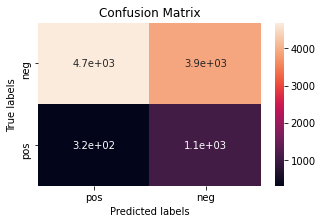

In [53]:
rcParams['figure.figsize'] = 5,3
rm.accuracy('TextBlob',dataframe)
rm.plot_conf_matrix('TextBlob',dataframe)


Polarity density distribution for TexBlob 


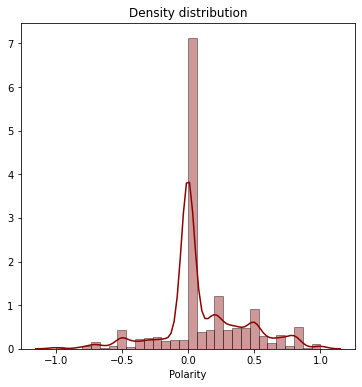

In [54]:
rcParams['figure.figsize'] = 6,6
print("Polarity density distribution for TexBlob ")
rm.plot_density('TextBlob')

Acurracy for  Vader is:  0.6124


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['pos', 'neg'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


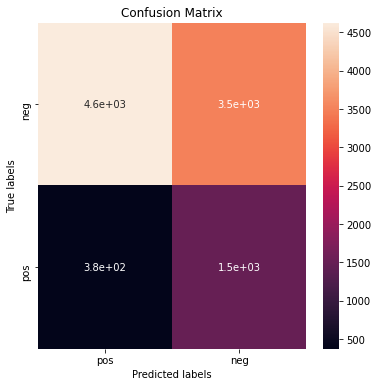

In [55]:
rm.accuracy('Vader',dataframe)
rm.plot_conf_matrix('Vader',dataframe)

Compound score distribution for Vader


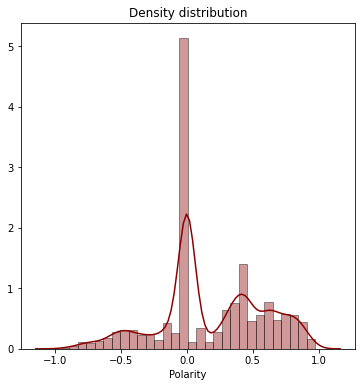

In [56]:
rcParams['figure.figsize'] = 6,6
print("Compound score distribution for Vader")
rm.plot_density('Vader')

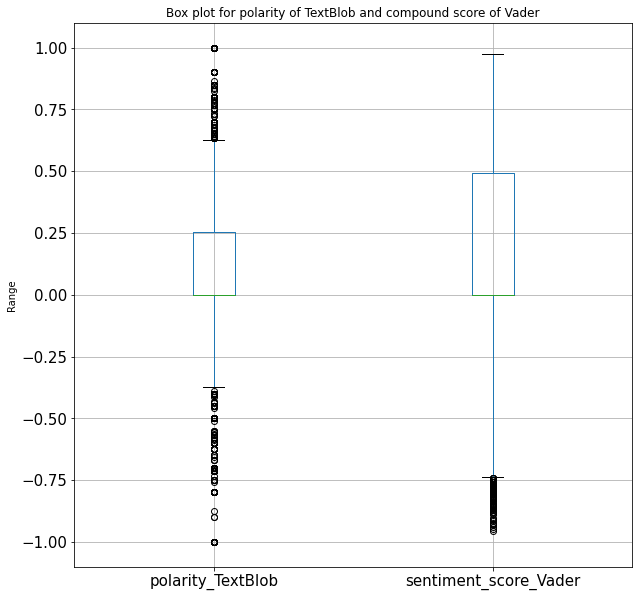

In [57]:
rm.plot_boxplot()